<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/base_models_gnn_convlstm_stacking_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# V5: GNN-ConvLSTM Stacking Ensemble

**Version:** 5.0  
**Date:** January 2026  
**Author:** Manuel Ricardo Perez Reyes  
**Status:** PROTOTYPE

---

## Architecture Overview

V5 implements a novel dual-branch stacking architecture that combines:

1. **Branch 1 (Grid):** ConvLSTM-Residual with BASIC features
2. **Branch 2 (Graph):** GNN-TAT-GAT with KCE features
3. **Grid-Graph Fusion:** Cross-attention alignment module
4. **Meta-Learner:** Context-aware weighted fusion

### Key Innovation

- **Architecture-specific feature routing:** BASIC -> ConvLSTM, KCE -> GNN
- **Grid-Graph fusion via cross-attention**
- **Interpretable elevation-dependent branch weighting**

### Target Performance

| Metric | ConvLSTM | GNN-TAT | V5 Target | V5 Excellent |
|--------|----------|---------|-----------|--------------|
| R2 (mean) | 0.653 | 0.628 | > 0.65 | > 0.70 |
| RMSE (mm) | 112.02 | 92.12 | < 85 | < 80 |
| Parameters | 2M | 98K | ~200K | <180K |

---

## 1. Environment Setup

In [1]:
# =============================================================================
# CELL 1: Environment Detection and Package Installation
# =============================================================================

import os
import sys
import shutil

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

# Version info from local machine where dataset was created
LOCAL_VERSIONS = {
    'netCDF4': '1.7.2',
    'h5py': '3.14.0',
    'HDF5_lib': '1.14.4',
    'netCDF_lib': '4.9.2'
}

if IN_COLAB:
    print("Running in Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')

    import subprocess
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'torch-geometric', '-q'], check=True)
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'netcdf4', 'h5py', 'xarray', 'h5netcdf', '-q'], check=True)

    import netCDF4
    import h5py

    print(f"Version check:")
    print(f"  netCDF4: {netCDF4.__version__}")
    print(f"  h5py: {h5py.__version__}")

    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
    DRIVE_DATA_FILE = f"{BASE_PATH}/data/output/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc"
    LOCAL_DATA_FILE = '/content/dataset_local.nc'

    if os.path.exists(DRIVE_DATA_FILE):
        if os.path.exists(LOCAL_DATA_FILE):
            os.remove(LOCAL_DATA_FILE)
        print("Copying dataset to local disk...")
        shutil.copy(DRIVE_DATA_FILE, LOCAL_DATA_FILE)
        print("Copy completed!")
        USE_LOCAL_DATA = True
    else:
        print(f"WARNING: Dataset not found: {DRIVE_DATA_FILE}")
        USE_LOCAL_DATA = False
else:
    print("Running locally")
    BASE_PATH = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
    if not BASE_PATH or BASE_PATH == '':
        BASE_PATH = r'd:\github.com\ninja-marduk\ml_precipitation_prediction'
    USE_LOCAL_DATA = False
    LOCAL_DATA_FILE = None

print(f"Base path: {BASE_PATH}")

if BASE_PATH not in sys.path:
    sys.path.insert(0, BASE_PATH)

print("Environment setup complete!")


Running in Google Colab
Mounted at /content/drive
Version check:
  netCDF4: 1.7.4
  h5py: 3.15.1
Copying dataset to local disk...
Copy completed!
Base path: /content/drive/MyDrive/ml_precipitation_prediction
Environment setup complete!


In [2]:
# =============================================================================
# CELL 2: Core Imports
# =============================================================================

# Disable TF oneDNN warnings
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Force CPU if CUDA has issues (cuDNN not found)
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Comment this line if you have working CUDA

import warnings
warnings.filterwarnings('ignore')

# Core scientific computing
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path

# PyTorch - force CPU mode for local without CUDA
import torch
torch.set_default_device('cpu')  # Force CPU
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Device setup (CPU for local, GPU for Colab)
if IN_COLAB and torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

# PyTorch Geometric
try:
    import torch_geometric
    from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool
    from torch_geometric.data import Data, Batch
    from torch_geometric.utils import dense_to_sparse, to_dense_adj
    TORCH_GEOMETRIC_AVAILABLE = True
    print(f"PyTorch Geometric version: {torch_geometric.__version__}")
except ImportError:
    TORCH_GEOMETRIC_AVAILABLE = False
    print("WARNING: PyTorch Geometric not available.")

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

# Utilities
import gc
import time
import logging
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Union
from collections import defaultdict
from dataclasses import dataclass, field

# Visualization (700 DPI for publication quality)
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['savefig.dpi'] = 700
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

try:
    import geopandas as gpd
    GEOPANDAS_AVAILABLE = True
except ImportError:
    GEOPANDAS_AVAILABLE = False

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    CARTOPY_AVAILABLE = True
except ImportError:
    CARTOPY_AVAILABLE = False

# Print versions
print(f"Environment Summary:")
print(f"  PyTorch: {torch.__version__}")
print(f"  NumPy: {np.__version__}")
print(f"  Device: {DEVICE}")
print(f"  CUDA available: {torch.cuda.is_available()}")
if DEVICE.type == 'cuda':
    print(f"  CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch Geometric version: 2.7.0
Environment Summary:
  PyTorch: 2.9.0+cpu
  NumPy: 2.0.2
  Device: cpu
  CUDA available: False


In [3]:
# =============================================================================
# CELL 3: V5 Configuration (V4 Compatible Format)
# =============================================================================

@dataclass
class V5Config:
    """V5 GNN-ConvLSTM Stacking Configuration (V4 Compatible)."""

    # Grid dimensions
    n_lat: int = 61
    n_lon: int = 65
    n_nodes: int = 61 * 65  # 3965 nodes

    # Feature sets (V4 compatible)
    n_basic_features: int = 12  # For ConvLSTM branch
    n_kce_features: int = 15    # For GNN branch (BASIC + 3 clusters)

    # Sequence parameters
    seq_len: int = 12  # 12 months input (V4: input_window = 60)
    input_window: int = 60  # V4 compatible
    horizons: List[int] = field(default_factory=lambda: [1, 3, 6, 12])

    # Feature sets dictionary (V4 compatible)
    feature_sets: Dict = field(default_factory=lambda: {
        'BASIC': [
            'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
            'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
            'elevation', 'slope', 'aspect'
        ],
        'KCE': [
            'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
            'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
            'elevation', 'slope', 'aspect', 'elev_high', 'elev_med', 'elev_low'
        ],
        'PAFC': [
            'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
            'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
            'elevation', 'slope', 'aspect', 'elev_high', 'elev_med', 'elev_low',
            'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag12'
        ]
    })

    # Branch 1: ConvLSTM Configuration
    convlstm_config: Dict = field(default_factory=lambda: {
        'hidden_channels': 32,
        'kernel_size': 3,
        'num_layers': 2,
        'dropout': 0.2,
        'output_dim': 64,
        'use_residual': True,
        'use_attention': True
    })

    # Branch 2: GNN-TAT Configuration (V4 compatible)
    gnn_config: Dict = field(default_factory=lambda: {
        'gnn_type': 'GAT',
        'hidden_dim': 64,
        'num_gnn_layers': 2,
        'num_heads': 4,
        'num_temporal_heads': 4,
        'num_lstm_layers': 1,
        'dropout': 0.2,
        'temporal_dropout': 0.1,
        'output_dim': 64,
        # V4 graph construction parameters
        'k_neighbors': 8,
        'distance_threshold_km': 50.0,
        'use_elevation_edges': True,
        'use_correlation_edges': True,
        'correlation_threshold': 0.3,
        'elevation_scale': 0.2,
        'max_edges': 500000
    })

    # Grid-Graph Fusion Configuration
    fusion_config: Dict = field(default_factory=lambda: {
        'type': 'cross_attention',
        'num_heads': 4,
        'hidden_dim': 64,
        'dropout': 0.1
    })

    # Meta-Learner Configuration
    meta_config: Dict = field(default_factory=lambda: {
        'context_features': ['elevation', 'season', 'horizon'],
        'hidden_dim': 64,
        'dropout': 0.1
    })

    # Training Configuration (V4 compatible)
    training_config: Dict = field(default_factory=lambda: {
        'batch_size': 2,          # V4: batch_size = 2 for large grids
        'learning_rate': 0.001,
        'weight_decay': 1e-5,
        'epochs': 150,            # V4: epochs = 150
        'patience': 50,           # V4: patience = 50
        'min_delta': 0.001,
        'warmup_epochs': 5,
        'gradient_accumulation_steps': 1,
        'prediction_batch_size': 2
    })

    # Data handling (V4 compatible)
    train_val_split: float = 0.8  # V4: train_val_split = 0.8
    light_mode: bool = True
    light_grid_size: int = 5

# Set paths based on environment
if IN_COLAB:
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    if USE_LOCAL_DATA:
        DATA_FILE = Path(LOCAL_DATA_FILE)
    else:
        DATA_FILE = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
else:
    BASE_PATH = Path(BASE_PATH) if 'BASE_PATH' in dir() else Path('.')
    DATA_FILE = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'

# Output directory (V4 compatible structure)
OUTPUT_ROOT = BASE_PATH / 'models' / 'output' / 'V5_STACKING'
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

# Initialize config
config = V5Config()

print(f"V5 Configuration initialized (V4 Compatible)")
print(f"  Grid: {config.n_lat}x{config.n_lon} = {config.n_nodes} nodes")
print(f"  BASIC features: {config.n_basic_features}")
print(f"  KCE features: {config.n_kce_features}")
print(f"  Horizons: {config.horizons}")
print(f"  Output: {OUTPUT_ROOT}")


V5 Configuration initialized (V4 Compatible)
  Grid: 61x65 = 3965 nodes
  BASIC features: 12
  KCE features: 15
  Horizons: [1, 3, 6, 12]
  Output: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V5_STACKING


## 2. Architecture Components

### 2.1 Branch 1: ConvLSTM with Residual and Attention

In [4]:
# =============================================================================
# 2.1 ConvLSTM Cell
# =============================================================================

class ConvLSTMCell(nn.Module):
    """Convolutional LSTM Cell for spatiotemporal modeling."""

    def __init__(self, in_channels: int, hidden_channels: int, kernel_size: int = 3):
        super().__init__()

        self.hidden_channels = hidden_channels
        padding = kernel_size // 2

        # Gates: input, forget, cell, output
        self.conv = nn.Conv2d(
            in_channels=in_channels + hidden_channels,
            out_channels=4 * hidden_channels,
            kernel_size=kernel_size,
            padding=padding,
            bias=True
        )

    def forward(self, x: torch.Tensor, state: Tuple[torch.Tensor, torch.Tensor]
               ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Args:
            x: Input tensor (B, C, H, W)
            state: Tuple of (h, c) each (B, hidden_channels, H, W)
        Returns:
            h_new: New hidden state
            (h_new, c_new): New state tuple
        """
        h, c = state

        # Concatenate input and hidden state
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)

        # Split into 4 gates
        i, f, g, o = torch.chunk(gates, 4, dim=1)

        # Apply activations
        i = torch.sigmoid(i)  # Input gate
        f = torch.sigmoid(f)  # Forget gate
        g = torch.tanh(g)     # Cell gate
        o = torch.sigmoid(o)  # Output gate

        # Update cell and hidden state
        c_new = f * c + i * g
        h_new = o * torch.tanh(c_new)

        return h_new, (h_new, c_new)

    def init_hidden(self, batch_size: int, height: int, width: int,
                    device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        """Initialize hidden state."""
        h = torch.zeros(batch_size, self.hidden_channels, height, width, device=device)
        c = torch.zeros(batch_size, self.hidden_channels, height, width, device=device)
        return (h, c)


class SpatialAttention(nn.Module):
    """Spatial attention module for ConvLSTM output."""

    def __init__(self, in_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 4, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 4, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Apply spatial attention."""
        attn = self.conv(x)
        return x * attn


class ConvLSTMBranch(nn.Module):
    """
    Branch 1: ConvLSTM with Residual connections and Spatial Attention.

    Processes grid-based BASIC features using convolutional LSTM layers
    with residual connections for better gradient flow.
    """

    def __init__(self, config: V5Config):
        super().__init__()

        cfg = config.convlstm_config
        in_channels = config.n_basic_features
        hidden_channels = cfg['hidden_channels']
        num_layers = cfg['num_layers']
        output_dim = cfg['output_dim']

        self.num_layers = num_layers
        self.hidden_channels = hidden_channels
        self.use_residual = cfg['use_residual']
        self.use_attention = cfg['use_attention']

        # ConvLSTM layers
        self.cells = nn.ModuleList()
        self.norms = nn.ModuleList()

        for i in range(num_layers):
            in_ch = in_channels if i == 0 else hidden_channels
            self.cells.append(ConvLSTMCell(in_ch, hidden_channels, cfg['kernel_size']))
            self.norms.append(nn.BatchNorm2d(hidden_channels))

        # Residual projection (if input channels differ)
        if self.use_residual:
            self.residual_proj = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)

        # Spatial attention
        if self.use_attention:
            self.spatial_attn = SpatialAttention(hidden_channels)

        # Output projection: flatten grid and project to output_dim
        self.output_proj = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Flatten(),
            nn.Linear(hidden_channels, output_dim),
            nn.LayerNorm(output_dim),
            nn.Dropout(cfg['dropout'])
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor (B, T, C, H, W) - batch, time, channels, height, width
        Returns:
            output: (B, output_dim) - branch embedding
        """
        batch_size, seq_len, channels, height, width = x.shape
        device = x.device

        # Initialize hidden states for all layers
        states = [cell.init_hidden(batch_size, height, width, device)
                  for cell in self.cells]

        # Process sequence through ConvLSTM layers
        for t in range(seq_len):
            x_t = x[:, t]  # (B, C, H, W)

            # Save first layer input for residual
            if self.use_residual and t == seq_len - 1:
                residual = self.residual_proj(x_t)

            # Pass through all layers
            for layer_idx, (cell, norm) in enumerate(zip(self.cells, self.norms)):
                h, states[layer_idx] = cell(x_t, states[layer_idx])
                h = norm(h)
                x_t = h  # Input to next layer

        # Get final hidden state
        output = h

        # Add residual connection
        if self.use_residual:
            output = output + residual

        # Apply spatial attention
        if self.use_attention:
            output = self.spatial_attn(output)

        # Project to output dimension
        output = self.output_proj(output)

        return output


# Test ConvLSTM Branch
print("Testing ConvLSTM Branch...")
convlstm_branch = ConvLSTMBranch(config).to(DEVICE)
test_input = torch.randn(2, 12, 12, 61, 65).to(DEVICE)  # (B, T, C, H, W)
test_output = convlstm_branch(test_input)
print(f"  Input shape: {test_input.shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  Parameters: {sum(p.numel() for p in convlstm_branch.parameters()):,}")

Testing ConvLSTM Branch...
  Input shape: torch.Size([2, 12, 12, 61, 65])
  Output shape: torch.Size([2, 64])
  Parameters: 127,729


### 2.2 Branch 2: GNN-TAT (from V4)

In [5]:
# =============================================================================
# 2.2 GNN-TAT Components (adapted from V4)
# =============================================================================

class TemporalAttention(nn.Module):
    """Multi-Head Temporal Attention module with residual connection."""

    def __init__(self, input_dim: int, hidden_dim: int, num_heads: int, dropout: float = 0.1):
        super().__init__()

        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        self.hidden_dim = hidden_dim

        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"

        # Query, Key, Value projections
        self.q_proj = nn.Linear(input_dim, hidden_dim)
        self.k_proj = nn.Linear(input_dim, hidden_dim)
        self.v_proj = nn.Linear(input_dim, hidden_dim)

        # Output projection
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)

        # Residual projection
        self.residual_proj = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else nn.Identity()

        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """(B, T, D) -> (B, T, hidden_dim)"""
        batch_size, seq_len, _ = x.shape

        residual = self.residual_proj(x)

        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention
        attn = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_dim)
        out = self.out_proj(out)

        # Residual + LayerNorm
        out = self.layer_norm(out + residual)

        return out


class SpatialGNNEncoder(nn.Module):
    """GNN Encoder for spatial dependencies (GAT, GCN, or SAGE)."""

    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int,
                 gnn_type: str = 'GAT', num_heads: int = 4, dropout: float = 0.1):
        super().__init__()

        self.num_layers = num_layers
        self.gnn_type = gnn_type
        self.hidden_dim = hidden_dim

        self.input_proj = nn.Linear(input_dim, hidden_dim)

        self.gnn_layers = nn.ModuleList()
        self.norms = nn.ModuleList()

        for _ in range(num_layers):
            if gnn_type == 'GAT':
                layer = GATConv(hidden_dim, hidden_dim // num_heads,
                               heads=num_heads, dropout=dropout, concat=True)
            elif gnn_type == 'SAGE':
                layer = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
            else:  # GCN
                layer = GCNConv(hidden_dim, hidden_dim, add_self_loops=True, normalize=True)

            self.gnn_layers.append(layer)
            self.norms.append(nn.LayerNorm(hidden_dim))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor,
                edge_weight: Optional[torch.Tensor] = None) -> torch.Tensor:
        """(N, D_in) -> (N, hidden_dim)"""
        x = self.input_proj(x)

        for gnn, norm in zip(self.gnn_layers, self.norms):
            residual = x

            if self.gnn_type == 'GAT':
                x = gnn(x, edge_index)
            else:
                x = gnn(x, edge_index, edge_weight=edge_weight)

            x = F.relu(x)
            x = norm(x)
            x = self.dropout(x)
            x = x + residual  # Residual connection

        return x


class GNNTATBranch(nn.Module):
    """
    Branch 2: GNN-TAT (Graph Neural Network with Temporal Attention).

    Processes graph-based KCE features using:
    1. Spatial GNN encoder (GAT/GCN/SAGE)
    2. Temporal attention across timesteps
    3. LSTM for sequence modeling
    """

    def __init__(self, config: V5Config):
        super().__init__()

        cfg = config.gnn_config
        n_features = config.n_kce_features
        hidden_dim = cfg['hidden_dim']
        output_dim = cfg['output_dim']

        self.hidden_dim = hidden_dim
        self.n_nodes = config.n_nodes

        # Spatial GNN Encoder
        self.gnn_encoder = SpatialGNNEncoder(
            input_dim=n_features,
            hidden_dim=hidden_dim,
            num_layers=cfg['num_gnn_layers'],
            gnn_type=cfg['gnn_type'],
            num_heads=cfg['num_heads'],
            dropout=cfg['dropout']
        )

        # Temporal Attention
        self.temporal_attn = TemporalAttention(
            input_dim=hidden_dim,
            hidden_dim=hidden_dim,
            num_heads=cfg['num_temporal_heads'],
            dropout=cfg['temporal_dropout']
        )

        # LSTM for sequence modeling
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=cfg['num_lstm_layers'],
            batch_first=True,
            dropout=cfg['dropout'] if cfg['num_lstm_layers'] > 1 else 0
        )

        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.Dropout(cfg['dropout'])
        )

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor,
                edge_weight: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Node features (B, T, N, F) - batch, time, nodes, features
            edge_index: Graph connectivity (2, E)
            edge_weight: Optional edge weights (E,)
        Returns:
            output: Global embedding (B, output_dim)
            node_embeddings: Per-node embeddings (B, N, output_dim)
        """
        batch_size, seq_len, n_nodes, n_features = x.shape

        # Process each timestep through GNN
        gnn_outputs = []
        for t in range(seq_len):
            x_t = x[:, t]  # (B, N, F)

            # Flatten batch for GNN processing
            x_flat = x_t.reshape(-1, n_features)  # (B*N, F)

            # Adjust edge_index for batched graphs
            batch_edge_index = self._expand_edge_index(edge_index, batch_size, n_nodes)

            # GNN forward
            h = self.gnn_encoder(x_flat, batch_edge_index, edge_weight)
            h = h.view(batch_size, n_nodes, -1)  # (B, N, hidden_dim)

            gnn_outputs.append(h)

        # Stack temporal outputs: (B, T, N, hidden_dim)
        gnn_outputs = torch.stack(gnn_outputs, dim=1)

        # Apply temporal attention per node
        # Reshape to (B*N, T, hidden_dim) for temporal processing
        temporal_input = gnn_outputs.permute(0, 2, 1, 3).reshape(-1, seq_len, self.hidden_dim)
        temporal_out = self.temporal_attn(temporal_input)  # (B*N, T, hidden_dim)

        # LSTM processing
        lstm_out, _ = self.lstm(temporal_out)  # (B*N, T, hidden_dim)
        lstm_out = lstm_out[:, -1]  # Take last timestep: (B*N, hidden_dim)

        # Reshape to (B, N, hidden_dim)
        node_embeddings = lstm_out.view(batch_size, n_nodes, -1)

        # Project node embeddings
        node_embeddings = self.output_proj(node_embeddings)  # (B, N, output_dim)

        # Global embedding via mean pooling
        global_embedding = node_embeddings.mean(dim=1)  # (B, output_dim)

        return global_embedding, node_embeddings

    def _expand_edge_index(self, edge_index: torch.Tensor, batch_size: int,
                           n_nodes: int) -> torch.Tensor:
        """Expand edge_index for batched graph processing."""
        expanded = []
        for b in range(batch_size):
            offset = b * n_nodes
            expanded.append(edge_index + offset)
        return torch.cat(expanded, dim=1)


print("GNN-TAT Branch defined.")
print("Note: Full testing requires graph construction (see Section 3).")

GNN-TAT Branch defined.
Note: Full testing requires graph construction (see Section 3).


### 2.3 Grid-Graph Fusion Module

In [6]:
# =============================================================================
# 2.3 Grid-Graph Fusion via Cross-Attention
# =============================================================================

class GridGraphFusion(nn.Module):
    """
    Grid-Graph Fusion Module using Cross-Attention.

    Aligns grid-based ConvLSTM embeddings with graph-based GNN embeddings
    through cross-attention mechanism.

    - Query: GNN node embeddings
    - Key/Value: ConvLSTM grid embeddings (flattened to node positions)
    """

    def __init__(self, config: V5Config):
        super().__init__()

        cfg = config.fusion_config
        hidden_dim = cfg['hidden_dim']
        num_heads = cfg['num_heads']

        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        self.hidden_dim = hidden_dim

        # Cross-attention projections
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)  # From GNN
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)  # From ConvLSTM
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)  # From ConvLSTM

        self.out_proj = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(cfg['dropout'])

        self.scale = self.head_dim ** -0.5

        # Feed-forward network for fusion
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(cfg['dropout']),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )

    def forward(self, gnn_embeddings: torch.Tensor,
                convlstm_embedding: torch.Tensor) -> torch.Tensor:
        """
        Args:
            gnn_embeddings: Node embeddings from GNN branch (B, N, D)
            convlstm_embedding: Global embedding from ConvLSTM branch (B, D)
        Returns:
            fused: Fused embedding (B, D)
        """
        batch_size, n_nodes, dim = gnn_embeddings.shape

        # Expand ConvLSTM embedding for cross-attention
        # Use it as key/value for all nodes
        convlstm_expanded = convlstm_embedding.unsqueeze(1).expand(-1, n_nodes, -1)

        # Cross-attention: GNN queries attend to ConvLSTM
        Q = self.q_proj(gnn_embeddings)  # (B, N, D)
        K = self.k_proj(convlstm_expanded)  # (B, N, D)
        V = self.v_proj(convlstm_expanded)  # (B, N, D)

        # Reshape for multi-head attention
        Q = Q.view(batch_size, n_nodes, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, n_nodes, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, n_nodes, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention
        attn = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(batch_size, n_nodes, self.hidden_dim)
        out = self.out_proj(out)

        # Residual connection with GNN embeddings
        out = self.layer_norm(out + gnn_embeddings)

        # Global pooling
        fused_node = out.mean(dim=1)  # (B, D)

        # Combine with original ConvLSTM embedding through FFN
        combined = torch.cat([fused_node, convlstm_embedding], dim=-1)  # (B, 2D)
        fused = self.ffn(combined)  # (B, D)

        return fused


print("Grid-Graph Fusion Module defined.")

Grid-Graph Fusion Module defined.


### 2.4 Interpretable Meta-Learner

In [7]:
# =============================================================================
# 2.4 Context-Aware Meta-Learner
# =============================================================================

class ContextAwareMetaLearner(nn.Module):
    """
    Interpretable Meta-Learner for context-dependent branch weighting.

    Uses context features (elevation, season, horizon) to learn
    dynamic weights for combining branch outputs.

    Provides interpretability through:
    - Branch contribution weights (w1, w2)
    - Context-specific weight patterns
    """

    def __init__(self, config: V5Config):
        super().__init__()

        cfg = config.meta_config
        hidden_dim = cfg['hidden_dim']
        branch_dim = config.convlstm_config['output_dim']  # Same for both branches

        # Context encoder
        # Input: [mean_elevation, season_sin, season_cos, horizon]
        context_dim = 4
        self.context_encoder = nn.Sequential(
            nn.Linear(context_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(cfg['dropout']),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )

        # Weight generator: context -> branch weights
        self.weight_generator = nn.Sequential(
            nn.Linear(hidden_dim + branch_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(cfg['dropout']),
            nn.Linear(hidden_dim, 2),  # 2 branch weights
            nn.Softmax(dim=-1)
        )

        # Final output projection
        self.output_proj = nn.Sequential(
            nn.Linear(branch_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Precipitation prediction
        )

    def forward(self, convlstm_emb: torch.Tensor, gnn_emb: torch.Tensor,
                fused_emb: torch.Tensor, context: torch.Tensor
               ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            convlstm_emb: ConvLSTM branch embedding (B, D)
            gnn_emb: GNN branch embedding (B, D)
            fused_emb: Grid-Graph fused embedding (B, D)
            context: Context features (B, 4) - [elevation, sin, cos, horizon]
        Returns:
            prediction: Precipitation prediction (B, 1)
            weights: Branch weights (B, 2) for interpretability
        """
        # Encode context
        context_encoded = self.context_encoder(context)  # (B, hidden_dim)

        # Generate weights based on context and branch embeddings
        weight_input = torch.cat([context_encoded, convlstm_emb, gnn_emb], dim=-1)
        weights = self.weight_generator(weight_input)  # (B, 2)

        # Weighted combination of branch outputs
        w1, w2 = weights[:, 0:1], weights[:, 1:2]  # (B, 1) each
        combined = w1 * convlstm_emb + w2 * gnn_emb  # (B, D)

        # Add fused embedding as residual
        combined = combined + fused_emb

        # Final prediction
        prediction = self.output_proj(combined)  # (B, 1)

        return prediction, weights


print("Context-Aware Meta-Learner defined.")

Context-Aware Meta-Learner defined.


### 2.5 Complete V5 Stacking Model

In [8]:
# =============================================================================
# 2.5 V5 GNN-ConvLSTM Stacking Model
# =============================================================================

class V5StackingModel(nn.Module):
    """
    V5: GNN-ConvLSTM Stacking Ensemble.

    Architecture:
    ┌──────────────────────────────────────────────────────────────────┐
    │                    V5 GNN-ConvLSTM STACKING                      │
    ├──────────────────────────────────────────────────────────────────┤
    │  BRANCH 1 (Grid)              BRANCH 2 (Graph)                   │
    │  ─────────────────           ──────────────────                  │
    │  ConvLSTM-Residual           GNN-TAT-GAT                         │
    │  BASIC features              KCE features                        │
    │         │                           │                            │
    │         └─────────┬─────────────────┘                            │
    │                   ▼                                              │
    │         GRID-GRAPH FUSION MODULE                                 │
    │         (Cross-Attention Alignment)                              │
    │                   │                                              │
    │                   ▼                                              │
    │         INTERPRETABLE META-LEARNER                               │
    │         (Weighted fusion + error attribution)                    │
    └──────────────────────────────────────────────────────────────────┘
    """

    def __init__(self, config: V5Config):
        super().__init__()

        self.config = config

        # Branch 1: ConvLSTM with BASIC features
        self.convlstm_branch = ConvLSTMBranch(config)

        # Branch 2: GNN-TAT with KCE features
        self.gnn_branch = GNNTATBranch(config)

        # Grid-Graph Fusion
        self.fusion = GridGraphFusion(config)

        # Meta-Learner
        self.meta_learner = ContextAwareMetaLearner(config)

    def forward(self, x_basic: torch.Tensor, x_kce: torch.Tensor,
                edge_index: torch.Tensor, context: torch.Tensor,
                edge_weight: Optional[torch.Tensor] = None
               ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """
        Args:
            x_basic: BASIC features for ConvLSTM (B, T, C_basic, H, W)
            x_kce: KCE features for GNN (B, T, N, C_kce)
            edge_index: Graph connectivity (2, E)
            context: Context features (B, 4)
            edge_weight: Optional edge weights (E,)
        Returns:
            prediction: Precipitation prediction (B, 1)
            aux_outputs: Dictionary with branch weights and embeddings
        """
        # Branch 1: ConvLSTM
        convlstm_emb = self.convlstm_branch(x_basic)  # (B, D)

        # Branch 2: GNN-TAT
        gnn_emb, node_embeddings = self.gnn_branch(x_kce, edge_index, edge_weight)

        # Grid-Graph Fusion
        fused_emb = self.fusion(node_embeddings, convlstm_emb)  # (B, D)

        # Meta-Learner
        prediction, weights = self.meta_learner(
            convlstm_emb, gnn_emb, fused_emb, context
        )

        aux_outputs = {
            'branch_weights': weights,  # (B, 2)
            'convlstm_embedding': convlstm_emb,
            'gnn_embedding': gnn_emb,
            'fused_embedding': fused_emb,
            'node_embeddings': node_embeddings
        }

        return prediction, aux_outputs

    def count_parameters(self) -> Dict[str, int]:
        """Count parameters by component."""
        return {
            'convlstm_branch': sum(p.numel() for p in self.convlstm_branch.parameters()),
            'gnn_branch': sum(p.numel() for p in self.gnn_branch.parameters()),
            'fusion': sum(p.numel() for p in self.fusion.parameters()),
            'meta_learner': sum(p.numel() for p in self.meta_learner.parameters()),
            'total': sum(p.numel() for p in self.parameters())
        }


# Create model and count parameters
print("\n" + "="*60)
print("V5 STACKING MODEL SUMMARY")
print("="*60)

model = V5StackingModel(config).to(DEVICE)
param_counts = model.count_parameters()

print(f"\nParameter counts:")
for name, count in param_counts.items():
    print(f"  {name}: {count:,}")

print(f"\nTarget: ~200K parameters")
print(f"Actual: {param_counts['total']:,} parameters")
print(f"Status: {'OK' if param_counts['total'] < 250000 else 'EXCEEDS TARGET'}")


V5 STACKING MODEL SUMMARY

Parameter counts:
  convlstm_branch: 127,729
  gnn_branch: 64,192
  fusion: 41,664
  meta_learner: 21,315
  total: 254,900

Target: ~200K parameters
Actual: 254,900 parameters
Status: EXCEEDS TARGET


## 3. Graph Construction (from V4)

TODO: Copy graph construction code from V4 notebook:
- Elevation-weighted edges
- Distance-based connectivity
- Edge weight calculation

In [9]:
# =============================================================================
# 3.1 SpatialGraphBuilder (from V4)
# =============================================================================

class SpatialGraphBuilder:
    """
    Builds a spatial graph from precipitation grid data.

    Nodes: Each grid cell (lat, lon) is a node
    Edges: Based on:
        1. Geographic distance (k-NN or threshold)
        2. Elevation similarity
        3. Historical precipitation correlation
    """

    def __init__(self, lat_coords: np.ndarray, lon_coords: np.ndarray,
                 elevation: np.ndarray, config: Dict):
        """
        Initialize graph builder.

        Args:
            lat_coords: Latitude coordinates (1D array)
            lon_coords: Longitude coordinates (1D array)
            elevation: Elevation values (2D array: lat x lon)
            config: GNN configuration dictionary
        """
        self.lat_coords = lat_coords
        self.lon_coords = lon_coords
        self.elevation = elevation
        self.config = config

        self.n_lat = len(lat_coords)
        self.n_lon = len(lon_coords)
        self.n_nodes = self.n_lat * self.n_lon

        # Create node positions (lat, lon for each grid cell)
        self.node_positions = self._create_node_positions()

        # Flatten elevation for node features
        self.node_elevations = elevation.flatten()

        print(f"SpatialGraphBuilder initialized:")
        print(f"  Nodes: {self.n_nodes} ({self.n_lat} x {self.n_lon})")

    def _create_node_positions(self) -> np.ndarray:
        """Create (lat, lon) positions for each node."""
        positions = []
        for i, lat in enumerate(self.lat_coords):
            for j, lon in enumerate(self.lon_coords):
                positions.append([lat, lon])
        return np.array(positions)

    def _node_index(self, i: int, j: int) -> int:
        """Convert (lat_idx, lon_idx) to flat node index."""
        return i * self.n_lon + j

    def _flat_to_grid(self, idx: int) -> Tuple[int, int]:
        """Convert flat node index to (lat_idx, lon_idx)."""
        return idx // self.n_lon, idx % self.n_lon

    def compute_distance_matrix(self) -> np.ndarray:
        """
        Compute pairwise distance matrix between all nodes.
        Uses Haversine formula for geographic coordinates.
        """
        # Convert to radians
        pos_rad = np.radians(self.node_positions)

        # Haversine distance
        lat1 = pos_rad[:, 0:1]
        lon1 = pos_rad[:, 1:2]
        lat2 = pos_rad[:, 0:1].T
        lon2 = pos_rad[:, 1:2].T

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))

        # Earth radius in km
        R = 6371.0
        distance_km = R * c

        return distance_km

    def compute_elevation_similarity(self) -> np.ndarray:
        """
        Compute elevation similarity matrix.
        Similarity = exp(-|elev_i - elev_j| / scale)
        """
        elev = self.node_elevations.reshape(-1, 1)
        elev_diff = np.abs(elev - elev.T)

        # Normalize by elevation range with configurable scale
        elev_range = elev.max() - elev.min() + 1e-6
        elevation_scale = self.config.get('elevation_scale', 0.2)
        similarity = np.exp(-elev_diff / (elev_range * elevation_scale))

        return similarity

    def compute_correlation_matrix(self, precip_series: np.ndarray) -> np.ndarray:
        """
        Compute precipitation correlation matrix.

        Args:
            precip_series: Precipitation time series (T, lat, lon)
        Returns:
            correlation: (n_nodes, n_nodes) correlation matrix
        """
        # Reshape to (T, n_nodes)
        T = precip_series.shape[0]
        precip_flat = precip_series.reshape(T, -1)

        # Compute correlation matrix
        correlation = np.corrcoef(precip_flat.T)

        # Handle NaN values
        correlation = np.nan_to_num(correlation, nan=0.0)

        return correlation

    def build_adjacency_matrix(self, precip_series: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Build the weighted adjacency matrix combining all edge types.

        Args:
            precip_series: Optional precipitation series for correlation edges

        Returns:
            edge_index: (2, num_edges) array of edge indices
            edge_weight: (num_edges,) array of edge weights
        """
        max_neighbors = self.config.get('max_neighbors', 8)
        edge_threshold = self.config.get('edge_threshold', 0.5)

        # Get configurable parameters (with defaults)
        distance_scale = self.config.get('distance_scale_km', 10.0)
        elevation_weight = self.config.get('elevation_weight', 0.3)
        correlation_weight = self.config.get('correlation_weight', 0.5)
        min_edge_weight = self.config.get('min_edge_weight', 0.01)

        # Initialize adjacency with zeros
        adj = np.zeros((self.n_nodes, self.n_nodes))

        # 1. Distance-based edges (k-NN)
        if self.config.get('use_distance_edges', True):
            dist_matrix = self.compute_distance_matrix()

            # Convert distance to similarity (inverse distance)
            dist_matrix[dist_matrix == 0] = 1e-6  # Avoid division by zero
            dist_similarity = 1.0 / (1.0 + dist_matrix / distance_scale)

            # Keep only k nearest neighbors
            for i in range(self.n_nodes):
                # Find k nearest neighbors (excluding self)
                neighbors = np.argsort(dist_matrix[i])[:max_neighbors + 1]
                neighbors = neighbors[neighbors != i][:max_neighbors]
                adj[i, neighbors] += dist_similarity[i, neighbors]

            print(f"  Distance edges added (k={max_neighbors}, scale={distance_scale}km)")

        # 2. Elevation-based edges
        if self.config.get('use_elevation_edges', True):
            elev_sim = self.compute_elevation_similarity()

            # Add elevation similarity to existing edges
            adj += elev_sim * elevation_weight
            print(f"  Elevation edges added (weight={elevation_weight})")

        # 3. Correlation-based edges
        if self.config.get('use_correlation_edges', False) and precip_series is not None:
            corr_matrix = self.compute_correlation_matrix(precip_series)

            # Only keep strong positive correlations
            corr_edges = np.maximum(corr_matrix - edge_threshold, 0)
            adj += corr_edges * correlation_weight
            print(f"  Correlation edges added (threshold={edge_threshold}, weight={correlation_weight})")

        # Remove self-loops (GCN will add them back if needed)
        np.fill_diagonal(adj, 0)

        # Normalize
        adj_max = adj.max()
        if adj_max > 0:
            adj = adj / adj_max

        # Symmetrize
        adj = (adj + adj.T) / 2

        # Convert to sparse format (edge_index, edge_weight)
        edge_index = []
        edge_weight = []

        for i in range(self.n_nodes):
            for j in range(self.n_nodes):
                if adj[i, j] > min_edge_weight:
                    edge_index.append([i, j])
                    edge_weight.append(adj[i, j])

        edge_index = np.array(edge_index).T  # Shape: (2, num_edges)
        edge_weight = np.array(edge_weight)  # Shape: (num_edges,)

        print(f"  Total edges: {len(edge_weight)}")
        print(f"  Average degree: {len(edge_weight) / self.n_nodes:.2f}")

        return edge_index, edge_weight

    def get_node_features(self) -> np.ndarray:
        """
        Get static node features (position, elevation).

        Returns:
            features: (n_nodes, 3) array with [lat, lon, elevation]
        """
        features = np.column_stack([
            self.node_positions,
            self.node_elevations
        ])
        return features


def create_v5_graph(lat_coords: np.ndarray, lon_coords: np.ndarray,
                    elevation: np.ndarray, precip_series: np.ndarray = None,
                    max_edges: int = 500000) -> Tuple[torch.Tensor, torch.Tensor, SpatialGraphBuilder]:
    """
    Create spatial graph for V5 with memory-efficient edge pruning.

    Args:
        lat_coords: Latitude coordinates
        lon_coords: Longitude coordinates
        elevation: Elevation grid
        precip_series: Optional precipitation time series
        max_edges: Maximum number of edges (for memory efficiency)

    Returns:
        edge_index: (2, E) tensor
        edge_weight: (E,) tensor
        graph_builder: SpatialGraphBuilder instance
    """
    # Graph configuration
    graph_config = {
        'max_neighbors': 8,
        'edge_threshold': 0.5,
        'distance_scale_km': 10.0,
        'elevation_weight': 0.3,
        'elevation_scale': 0.2,
        'correlation_weight': 0.5,
        'min_edge_weight': 0.01,
        'use_distance_edges': True,
        'use_elevation_edges': True,
        'use_correlation_edges': precip_series is not None
    }

    # Build graph
    graph_builder = SpatialGraphBuilder(lat_coords, lon_coords, elevation, graph_config)
    edge_index, edge_weight = graph_builder.build_adjacency_matrix(precip_series)

    # Prune edges if too many (for memory efficiency)
    if len(edge_weight) > max_edges:
        print(f"\nPruning edges from {len(edge_weight):,} to {max_edges:,}...")
        top_indices = np.argsort(edge_weight)[-max_edges:]
        edge_index = edge_index[:, top_indices]
        edge_weight = edge_weight[top_indices]
        print(f"  Reduced to {len(edge_weight):,} edges")

    # Convert to PyTorch tensors
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
    edge_weight_tensor = torch.tensor(edge_weight, dtype=torch.float32)

    return edge_index_tensor, edge_weight_tensor, graph_builder


# Test graph construction with dummy data
print("Testing SpatialGraphBuilder...")
dummy_lat = np.linspace(5.0, 8.0, 61)
dummy_lon = np.linspace(-74.0, -71.0, 65)
dummy_elevation = np.random.uniform(500, 4000, (61, 65))

edge_index, edge_weight, graph_builder = create_v5_graph(
    dummy_lat, dummy_lon, dummy_elevation, max_edges=100000
)

print(f"\nGraph created:")
print(f"  Nodes: {graph_builder.n_nodes}")
print(f"  Edges: {edge_index.shape[1]}")
print(f"  Edge index shape: {edge_index.shape}")
print(f"  Edge weight shape: {edge_weight.shape}")

Testing SpatialGraphBuilder...
SpatialGraphBuilder initialized:
  Nodes: 3965 (61 x 65)
  Distance edges added (k=8, scale=10.0km)
  Elevation edges added (weight=0.3)
  Total edges: 14151240
  Average degree: 3569.04

Pruning edges from 14,151,240 to 100,000...
  Reduced to 100,000 edges

Graph created:
  Nodes: 3965
  Edges: 100000
  Edge index shape: torch.Size([2, 100000])
  Edge weight shape: torch.Size([100000])


## 4. Data Loading

Real data loading pipeline for V5:
- **BASIC features** → ConvLSTM branch (grid format: B, T, C, H, W)
- **KCE features** → GNN branch (graph format: B, T, N, C)

### Feature Sets

| Set | Features | Count | Branch |
|-----|----------|-------|--------|
| BASIC | temporal + precip stats + base topo | 12 | ConvLSTM |
| KCE | BASIC + elevation clusters | 15 | GNN |


In [10]:
# =============================================================================
# 4.1 Data Loading Configuration
# =============================================================================

@dataclass
class DataConfig:
    """Configuration for data loading."""

    # Feature sets for each branch
    basic_features: List[str] = field(default_factory=lambda: [
        'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
        'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
        'elevation', 'slope', 'aspect'
    ])

    kce_features: List[str] = field(default_factory=lambda: [
        'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
        'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
        'elevation', 'slope', 'aspect', 'elev_high', 'elev_med', 'elev_low'
    ])

    # Data parameters
    input_window: int = 60  # 60 months input (5 years)
    train_val_split: float = 0.9
    target_var: str = 'total_precipitation'

    # Light mode settings
    light_mode: bool = False
    light_grid_size: int = 5


# Initialize data config
data_config = DataConfig()
print(f"Data Configuration:")
print(f"  BASIC features: {len(data_config.basic_features)}")
print(f"  KCE features: {len(data_config.kce_features)}")
print(f"  Input window: {data_config.input_window} months")
print(f"  Train/Val split: {data_config.train_val_split}")

Data Configuration:
  BASIC features: 12
  KCE features: 15
  Input window: 60 months
  Train/Val split: 0.9


In [11]:
# =============================================================================
# 4.2 Dataset Loading Functions
# =============================================================================

import xarray as xr
from sklearn.preprocessing import StandardScaler


def load_dataset(data_path: Path, light_mode: bool = False,
                 light_grid_size: int = 5) -> Tuple[xr.Dataset, np.ndarray, np.ndarray, int, int]:
    """
    Load NetCDF dataset with optional light mode for testing.

    Args:
        data_path: Path to NetCDF file
        light_mode: If True, use subset of grid for faster testing
        light_grid_size: Size of subset grid (e.g., 5 for 5x5)

    Returns:
        ds: xarray Dataset
        lat_coords: Latitude coordinates
        lon_coords: Longitude coordinates
        n_lat: Number of latitude points
        n_lon: Number of longitude points
    """
    print(f"Loading data from: {data_path}")

    # Try different engines
    engines = ['h5netcdf', 'netcdf4', 'scipy']
    ds = None

    for engine in engines:
        try:
            print(f"  Trying engine: {engine}...")
            ds = xr.open_dataset(data_path, engine=engine)
            print(f"  Success with engine: {engine}")
            break
        except Exception as e:
            print(f"  Engine {engine} failed: {type(e).__name__}")
            continue

    if ds is None:
        raise RuntimeError(f"Could not open dataset with any engine.")

    print(f"  Original shape: time={len(ds.time)}, lat={len(ds.latitude)}, lon={len(ds.longitude)}")

    # Optional light mode: subset to center region
    if light_mode:
        lat_center = len(ds.latitude) // 2
        lon_center = len(ds.longitude) // 2
        lat_start = lat_center - light_grid_size // 2
        lat_end = lat_start + light_grid_size
        lon_start = lon_center - light_grid_size // 2
        lon_end = lon_start + light_grid_size

        ds = ds.isel(
            latitude=slice(lat_start, lat_end),
            longitude=slice(lon_start, lon_end)
        )
        print(f"  Light mode applied: lat={len(ds.latitude)}, lon={len(ds.longitude)}")

    n_lat = len(ds.latitude)
    n_lon = len(ds.longitude)
    lat_coords = ds.latitude.values
    lon_coords = ds.longitude.values

    print(f"  Final grid: {n_lat} x {n_lon} = {n_lat * n_lon} nodes")

    return ds, lat_coords, lon_coords, n_lat, n_lon


def extract_features(ds: xr.Dataset, feature_list: List[str],
                     n_lat: int, n_lon: int) -> np.ndarray:
    """
    Extract and stack features from dataset.

    Args:
        ds: xarray Dataset
        feature_list: List of feature names
        n_lat: Number of latitude points
        n_lon: Number of longitude points

    Returns:
        X: Feature array (T, lat, lon, n_features)
    """
    feature_arrays = []

    for feat in feature_list:
        if feat in ds.data_vars:
            arr = ds[feat].values
        elif feat in ds.coords:
            if feat == 'time':
                continue
            # Broadcast coordinate to full grid
            arr = np.broadcast_to(
                ds.coords[feat].values.reshape(-1, 1, 1),
                (len(ds.time), n_lat, n_lon)
            )
        else:
            print(f"  WARNING: Feature '{feat}' not found, skipping")
            continue

        # Ensure 3D shape (T, lat, lon)
        if len(arr.shape) == 2:
            # Static feature: broadcast to time
            arr = np.broadcast_to(arr, (len(ds.time), n_lat, n_lon))

        feature_arrays.append(arr)

    # Stack features: (T, lat, lon, n_features)
    X = np.stack(feature_arrays, axis=-1).astype(np.float32)

    # Handle NaN
    X = np.nan_to_num(X, nan=0.0)

    return X


def windowed_arrays(X: np.ndarray, y: np.ndarray, input_window: int,
                   horizon: int, start_indices: List[int] = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create windowed arrays for sequence-to-sequence learning.

    Args:
        X: Features (T, lat, lon, n_features)
        y: Target (T, lat, lon)
        input_window: Input sequence length
        horizon: Prediction horizon
        start_indices: Optional list of starting indices for windows

    Returns:
        X_windows: (N, input_window, lat, lon, n_features)
        y_windows: (N, horizon, lat, lon)
    """
    T = X.shape[0]

    if start_indices is None:
        max_start = T - input_window - horizon + 1
        start_indices = list(range(max_start))

    X_windows = []
    y_windows = []

    for start in start_indices:
        x_end = start + input_window
        y_start = x_end
        y_end = y_start + horizon

        if y_end <= T:
            X_windows.append(X[start:x_end])
            y_windows.append(y[y_start:y_end])

    return np.array(X_windows), np.array(y_windows)


def compute_split_indices(T: int, input_window: int, horizon: int,
                          split_ratio: float) -> Tuple[List[int], List[int]]:
    """
    Compute train/validation split indices for time series.

    Args:
        T: Total timesteps
        input_window: Input sequence length
        horizon: Prediction horizon
        split_ratio: Fraction for training (e.g., 0.9)

    Returns:
        train_indices: Starting indices for training windows
        val_indices: Starting indices for validation windows
    """
    max_start = T - input_window - horizon + 1
    n_train = int(max_start * split_ratio)

    train_indices = list(range(n_train))
    val_start = n_train
    val_indices = list(range(val_start, max_start))

    return train_indices, val_indices


print("Data loading functions defined.")

Data loading functions defined.


In [12]:
# =============================================================================
# 4.3 V5 Dual Dataset (Real Data)
# =============================================================================

class V5DualDataset(Dataset):
    """
    Dataset providing both BASIC (grid) and KCE (graph) features for V5.

    Handles:
    - BASIC features for ConvLSTM branch (B, T, C, H, W)
    - KCE features for GNN branch (B, T, N, C)
    - Context features for meta-learner
    - Target precipitation values
    """

    def __init__(self, X_basic: np.ndarray, X_kce: np.ndarray,
                 y: np.ndarray, elevation: np.ndarray,
                 horizon: int, scaler_y: StandardScaler = None):
        """
        Initialize V5 dataset.

        Args:
            X_basic: BASIC features (N, T, lat, lon, C_basic)
            X_kce: KCE features (N, T, lat, lon, C_kce)
            y: Target precipitation (N, H, lat, lon)
            elevation: Mean elevation for context (N,) or scalar
            horizon: Prediction horizon
            scaler_y: Scaler for target (for inverse transform)
        """
        super().__init__()

        self.n_samples = X_basic.shape[0]
        self.seq_len = X_basic.shape[1]
        self.n_lat = X_basic.shape[2]
        self.n_lon = X_basic.shape[3]
        self.n_nodes = self.n_lat * self.n_lon
        self.horizon = horizon
        self.scaler_y = scaler_y

        # Store elevation for context
        if isinstance(elevation, np.ndarray) and len(elevation.shape) > 0:
            self.mean_elevation = elevation.mean() if len(elevation.shape) > 1 else elevation.mean()
        else:
            self.mean_elevation = float(elevation)

        # BASIC features: (N, T, lat, lon, C) -> (N, T, C, lat, lon) for ConvLSTM
        self.X_basic = torch.tensor(
            np.transpose(X_basic, (0, 1, 4, 2, 3)),
            dtype=torch.float32
        )

        # KCE features: (N, T, lat, lon, C) -> (N, T, N_nodes, C) for GNN
        X_kce_reshaped = X_kce.reshape(
            X_kce.shape[0], X_kce.shape[1], -1, X_kce.shape[-1]
        )
        self.X_kce = torch.tensor(X_kce_reshaped, dtype=torch.float32)

        # Target: aggregate over horizon for single prediction
        # Shape: (N, H, lat, lon) -> (N, 1) mean precipitation
        self.y = torch.tensor(
            y[:, 0, :, :].mean(axis=(1, 2), keepdims=True),  # First horizon step, spatial mean
            dtype=torch.float32
        )

        # Full spatial target for evaluation
        self.y_spatial = torch.tensor(y, dtype=torch.float32)

        print(f"V5DualDataset initialized:")
        print(f"  Samples: {self.n_samples}")
        print(f"  X_basic shape: {self.X_basic.shape} (N, T, C, H, W)")
        print(f"  X_kce shape: {self.X_kce.shape} (N, T, N, C)")
        print(f"  y shape: {self.y.shape}")

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        # Create context features
        # [mean_elevation (normalized), season_sin, season_cos, horizon (normalized)]
        # Using placeholder values - actual values come from metadata
        month = (idx % 12)  # Approximate month from index
        season_sin = np.sin(2 * np.pi * month / 12)
        season_cos = np.cos(2 * np.pi * month / 12)

        context = torch.tensor([
            self.mean_elevation / 4000.0,  # Normalize elevation (max ~4000m in Boyaca)
            season_sin,
            season_cos,
            self.horizon / 12.0  # Normalize horizon
        ], dtype=torch.float32)

        return {
            'x_basic': self.X_basic[idx],      # (T, C, H, W)
            'x_kce': self.X_kce[idx],          # (T, N, C)
            'context': context,                 # (4,)
            'y': self.y[idx],                  # (1,)
            'y_spatial': self.y_spatial[idx]   # (H, lat, lon)
        }


def prepare_v5_data(ds: xr.Dataset, data_config: DataConfig,
                    n_lat: int, n_lon: int, horizon: int
                   ) -> Tuple[V5DualDataset, V5DualDataset, np.ndarray, StandardScaler]:
    """
    Prepare V5 dual datasets for training and validation.

    Args:
        ds: xarray Dataset
        data_config: DataConfig with feature lists
        n_lat: Number of latitude points
        n_lon: Number of longitude points
        horizon: Prediction horizon

    Returns:
        train_dataset: V5DualDataset for training
        val_dataset: V5DualDataset for validation
        elevation: Elevation array for graph construction
        scaler_y: Target scaler
    """
    print(f"\nPreparing V5 data for horizon H={horizon}...")

    # Extract features
    print(f"  Extracting BASIC features ({len(data_config.basic_features)} features)...")
    X_basic = extract_features(ds, data_config.basic_features, n_lat, n_lon)
    print(f"    X_basic shape: {X_basic.shape}")

    print(f"  Extracting KCE features ({len(data_config.kce_features)} features)...")
    X_kce = extract_features(ds, data_config.kce_features, n_lat, n_lon)
    print(f"    X_kce shape: {X_kce.shape}")

    # Target
    y = ds[data_config.target_var].values.astype(np.float32)
    y = np.nan_to_num(y, nan=0.0)
    print(f"  Target shape: {y.shape}")

    # Elevation for context and graph
    if 'elevation' in ds.data_vars:
        elevation = ds['elevation'].values
        if len(elevation.shape) == 3:
            elevation = elevation[0]  # Take first timestep (static)
    elif 'elevation' in ds.coords:
        elevation = ds.coords['elevation'].values
    else:
        print("  WARNING: Elevation not found, using zeros")
        elevation = np.zeros((n_lat, n_lon))

    # Compute split indices
    T = len(ds.time)
    train_idx, val_idx = compute_split_indices(
        T, data_config.input_window, horizon, data_config.train_val_split
    )
    print(f"  Train windows: {len(train_idx)}, Val windows: {len(val_idx)}")

    # Create windowed arrays
    X_basic_tr, y_tr = windowed_arrays(X_basic, y, data_config.input_window, horizon, train_idx)
    X_basic_va, y_va = windowed_arrays(X_basic, y, data_config.input_window, horizon, val_idx)
    X_kce_tr, _ = windowed_arrays(X_kce, y, data_config.input_window, horizon, train_idx)
    X_kce_va, _ = windowed_arrays(X_kce, y, data_config.input_window, horizon, val_idx)

    print(f"  X_basic_tr: {X_basic_tr.shape}, X_kce_tr: {X_kce_tr.shape}")
    print(f"  X_basic_va: {X_basic_va.shape}, X_kce_va: {X_kce_va.shape}")

    # Scale features
    scaler_basic = StandardScaler()
    scaler_kce = StandardScaler()
    scaler_y = StandardScaler()

    # Fit on training data (flatten for scaling)
    X_basic_tr_flat = X_basic_tr.reshape(-1, X_basic_tr.shape[-1])
    X_kce_tr_flat = X_kce_tr.reshape(-1, X_kce_tr.shape[-1])
    y_tr_flat = y_tr.reshape(-1, 1)

    scaler_basic.fit(X_basic_tr_flat)
    scaler_kce.fit(X_kce_tr_flat)
    scaler_y.fit(y_tr_flat)

    # Transform
    X_basic_tr_sc = scaler_basic.transform(X_basic_tr.reshape(-1, X_basic_tr.shape[-1])).reshape(X_basic_tr.shape)
    X_basic_va_sc = scaler_basic.transform(X_basic_va.reshape(-1, X_basic_va.shape[-1])).reshape(X_basic_va.shape)
    X_kce_tr_sc = scaler_kce.transform(X_kce_tr.reshape(-1, X_kce_tr.shape[-1])).reshape(X_kce_tr.shape)
    X_kce_va_sc = scaler_kce.transform(X_kce_va.reshape(-1, X_kce_va.shape[-1])).reshape(X_kce_va.shape)
    y_tr_sc = scaler_y.transform(y_tr.reshape(-1, 1)).reshape(y_tr.shape)
    y_va_sc = scaler_y.transform(y_va.reshape(-1, 1)).reshape(y_va.shape)

    print(f"  Scaling complete.")

    # Create datasets
    train_dataset = V5DualDataset(
        X_basic_tr_sc, X_kce_tr_sc, y_tr_sc, elevation, horizon, scaler_y
    )
    val_dataset = V5DualDataset(
        X_basic_va_sc, X_kce_va_sc, y_va_sc, elevation, horizon, scaler_y
    )

    return train_dataset, val_dataset, elevation, scaler_y


print("V5DualDataset and prepare_v5_data defined.")

V5DualDataset and prepare_v5_data defined.


In [13]:
# =============================================================================
# 4.4 Load Real Data (or Synthetic Fallback)
# =============================================================================

# Data paths
if IN_COLAB:
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    DATA_FILE = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
else:
    BASE_PATH = Path('.')
    DATA_FILE = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'

# Configuration
USE_LIGHT_MODE = True  # Set to False for full grid
LIGHT_GRID_SIZE = 5     # 5x5 for testing
HORIZON = 12            # Prediction horizon

print(f"Data file: {DATA_FILE}")
print(f"Light mode: {USE_LIGHT_MODE} (grid: {LIGHT_GRID_SIZE}x{LIGHT_GRID_SIZE})")
print(f"Horizon: {HORIZON} months")

# Try to load real data, fall back to synthetic
USE_REAL_DATA = False
ds = None
train_dataset = None
val_dataset = None
elevation = None

try:
    if DATA_FILE.exists():
        print("\nLoading real data...")
        ds, lat_coords, lon_coords, n_lat, n_lon = load_dataset(
            DATA_FILE,
            light_mode=USE_LIGHT_MODE,
            light_grid_size=LIGHT_GRID_SIZE
        )

        # Update config with actual dimensions
        config.n_lat = n_lat
        config.n_lon = n_lon
        config.n_nodes = n_lat * n_lon

        # Prepare datasets
        train_dataset, val_dataset, elevation, scaler_y = prepare_v5_data(
            ds, data_config, n_lat, n_lon, HORIZON
        )

        USE_REAL_DATA = True
        print(f"\nReal data loaded successfully!")
    else:
        print(f"\nData file not found: {DATA_FILE}")
        print("Using synthetic data for testing...")

except Exception as e:
    print(f"\nError loading real data: {e}")
    print("Using synthetic data for testing...")

# Fallback to synthetic data
if not USE_REAL_DATA:
    print("\nGenerating synthetic data for prototype testing...")

    if USE_LIGHT_MODE:
        config.n_lat = LIGHT_GRID_SIZE
        config.n_lon = LIGHT_GRID_SIZE
        config.n_nodes = LIGHT_GRID_SIZE * LIGHT_GRID_SIZE

    # Create synthetic datasets
    n_train = 100
    n_val = 20
    seq_len = 60

    # BASIC: (N, T, C, H, W) for ConvLSTM
    X_basic_tr = np.random.randn(n_train, seq_len, config.n_lat, config.n_lon, config.n_basic_features).astype(np.float32)
    X_basic_va = np.random.randn(n_val, seq_len, config.n_lat, config.n_lon, config.n_basic_features).astype(np.float32)

    # KCE: (N, T, lat, lon, C) for GNN
    X_kce_tr = np.random.randn(n_train, seq_len, config.n_lat, config.n_lon, config.n_kce_features).astype(np.float32)
    X_kce_va = np.random.randn(n_val, seq_len, config.n_lat, config.n_lon, config.n_kce_features).astype(np.float32)

    # Target: (N, H, lat, lon)
    y_tr = np.random.randn(n_train, HORIZON, config.n_lat, config.n_lon).astype(np.float32)
    y_va = np.random.randn(n_val, HORIZON, config.n_lat, config.n_lon).astype(np.float32)

    # Elevation
    elevation = np.random.uniform(500, 4000, (config.n_lat, config.n_lon)).astype(np.float32)

    # Coordinates
    lat_coords = np.linspace(5.0, 8.0, config.n_lat)
    lon_coords = np.linspace(-74.0, -71.0, config.n_lon)

    train_dataset = V5DualDataset(X_basic_tr, X_kce_tr, y_tr, elevation, HORIZON)
    val_dataset = V5DualDataset(X_basic_va, X_kce_va, y_va, elevation, HORIZON)

    print(f"Synthetic data generated.")

# Summary
print(f"\n{'='*60}")
print(f"DATA LOADING SUMMARY")
print(f"{'='*60}")
print(f"Data source: {'Real (CHIRPS/SRTM)' if USE_REAL_DATA else 'Synthetic'}")
print(f"Grid: {config.n_lat} x {config.n_lon} = {config.n_nodes} nodes")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Horizon: {HORIZON} months")

Data file: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc
Light mode: True (grid: 5x5)
Horizon: 12 months

Loading real data...
Loading data from: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc
  Trying engine: h5netcdf...
  Engine h5netcdf failed: RuntimeError
  Trying engine: netcdf4...
  Success with engine: netcdf4
  Original shape: time=518, lat=61, lon=65
  Light mode applied: lat=5, lon=5
  Final grid: 5 x 5 = 25 nodes

Preparing V5 data for horizon H=12...
  Extracting BASIC features (12 features)...
    X_basic shape: (518, 5, 5, 12)
  Extracting KCE features (15 features)...
    X_kce shape: (518, 5, 5, 15)
  Target shape: (518, 5, 5)
  Train windows: 402, Val windows: 45
  X_basic_tr: (402, 60, 5, 5, 12), X_kce_tr: (402, 60, 5, 5, 15)
  X_basic_va: 

In [14]:
# =============================================================================
# 4.5 Build Graph and Create Data Loaders
# =============================================================================

# Build spatial graph
print("Building spatial graph...")

# Get precipitation series for correlation edges (if real data)
if USE_REAL_DATA and ds is not None:
    precip_var = 'total_precipitation' if 'total_precipitation' in ds.data_vars else list(ds.data_vars)[0]
    precip_series = ds[precip_var].values
else:
    # Synthetic: no correlation edges
    precip_series = None

# Create graph
edge_index, edge_weight, graph_builder = create_v5_graph(
    lat_coords, lon_coords, elevation,
    precip_series=precip_series,
    max_edges=100000 if USE_LIGHT_MODE else 500000
)

# Move to device
edge_index = edge_index.to(DEVICE)
edge_weight = edge_weight.to(DEVICE)

print(f"\nGraph Summary:")
print(f"  Nodes: {config.n_nodes}")
print(f"  Edges: {edge_index.shape[1]}")
print(f"  Avg degree: {edge_index.shape[1] / config.n_nodes:.2f}")

# Create data loaders
BATCH_SIZE = config.training_config['batch_size']
if USE_LIGHT_MODE:
    BATCH_SIZE = min(BATCH_SIZE, 8)  # Smaller batch for light mode

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nData Loaders:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

# Test batch
sample_batch = next(iter(train_loader))
print(f"\nSample Batch Shapes:")
for key, value in sample_batch.items():
    print(f"  {key}: {value.shape}")

Building spatial graph...
SpatialGraphBuilder initialized:
  Nodes: 25 (5 x 5)
  Distance edges added (k=8, scale=10.0km)
  Elevation edges added (weight=0.3)
  Correlation edges added (threshold=0.5, weight=0.5)
  Total edges: 600
  Average degree: 24.00

Graph Summary:
  Nodes: 25
  Edges: 600
  Avg degree: 24.00

Data Loaders:
  Batch size: 2
  Train batches: 201
  Val batches: 23

Sample Batch Shapes:
  x_basic: torch.Size([2, 60, 12, 5, 5])
  x_kce: torch.Size([2, 60, 25, 15])
  context: torch.Size([2, 4])
  y: torch.Size([2, 1, 1])
  y_spatial: torch.Size([2, 12, 5, 5])


## 5. Training Loop

Complete training pipeline with:
- Separate learning rates for branches and meta-learner
- Early stopping with patience
- Branch contribution logging for interpretability
- Checkpoint saving for best model


In [15]:
# =============================================================================
# 5.1 V5 Trainer with Full Functionality
# =============================================================================

from datetime import datetime
import json
import time


class V5Trainer:
    """
    Trainer for V5 GNN-ConvLSTM Stacking Model.

    Features:
    - Separate learning rates for branches and fusion/meta-learner
    - Early stopping with patience
    - Branch weight tracking for interpretability
    - Checkpoint saving
    """

    def __init__(self, model: V5StackingModel, config: V5Config,
                 edge_index: torch.Tensor, edge_weight: torch.Tensor,
                 output_dir: Path = None):
        self.model = model
        self.config = config
        self.edge_index = edge_index.to(DEVICE)
        self.edge_weight = edge_weight.to(DEVICE)

        train_cfg = config.training_config

        # Output directory for checkpoints
        self.output_dir = output_dir or Path('models/output/V5_STACKING')
        self.output_dir.mkdir(parents=True, exist_ok=True)

        # Optimizer with parameter groups (different LR for branches vs fusion)
        self.optimizer = torch.optim.AdamW([
            {'params': model.convlstm_branch.parameters(),
             'lr': train_cfg['learning_rate'], 'name': 'convlstm'},
            {'params': model.gnn_branch.parameters(),
             'lr': train_cfg['learning_rate'], 'name': 'gnn'},
            {'params': model.fusion.parameters(),
             'lr': train_cfg['learning_rate'] * 0.5, 'name': 'fusion'},
            {'params': model.meta_learner.parameters(),
             'lr': train_cfg['learning_rate'] * 0.5, 'name': 'meta_learner'}
        ], weight_decay=train_cfg['weight_decay'])

        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5
        )

        # Loss function
        self.criterion = nn.MSELoss()

        # Training state
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.epoch = 0

        # History tracking
        self.history = {
            'epoch': [],
            'train_loss': [],
            'val_loss': [],
            'branch_weights_convlstm': [],
            'branch_weights_gnn': [],
            'learning_rate': [],
            'epoch_time': []
        }

    def train_epoch(self, train_loader: DataLoader) -> Tuple[float, np.ndarray]:
        """Train for one epoch."""
        self.model.train()
        total_loss = 0.0
        weight_sum = torch.zeros(2, device=DEVICE)
        n_batches = 0

        for batch in train_loader:
            x_basic = batch['x_basic'].to(DEVICE)
            x_kce = batch['x_kce'].to(DEVICE)
            context = batch['context'].to(DEVICE)
            y = batch['y'].to(DEVICE)

            self.optimizer.zero_grad()

            # Forward pass
            pred, aux = self.model(
                x_basic, x_kce, self.edge_index, context, self.edge_weight
            )

            # Compute loss
            loss = self.criterion(pred, y)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Optimizer step
            self.optimizer.step()

            # Accumulate metrics
            total_loss += loss.item()
            weight_sum += aux['branch_weights'].mean(dim=0).detach()
            n_batches += 1

        avg_loss = total_loss / n_batches
        avg_weights = (weight_sum / n_batches).cpu().numpy()

        return avg_loss, avg_weights

    @torch.no_grad()
    def validate(self, val_loader: DataLoader) -> Tuple[float, np.ndarray]:
        """Validate model."""
        self.model.eval()
        total_loss = 0.0
        weight_sum = torch.zeros(2, device=DEVICE)
        n_batches = 0

        for batch in val_loader:
            x_basic = batch['x_basic'].to(DEVICE)
            x_kce = batch['x_kce'].to(DEVICE)
            context = batch['context'].to(DEVICE)
            y = batch['y'].to(DEVICE)

            pred, aux = self.model(
                x_basic, x_kce, self.edge_index, context, self.edge_weight
            )

            loss = self.criterion(pred, y)

            total_loss += loss.item()
            weight_sum += aux['branch_weights'].mean(dim=0)
            n_batches += 1

        avg_loss = total_loss / n_batches
        avg_weights = (weight_sum / n_batches).cpu().numpy()

        return avg_loss, avg_weights

    def save_checkpoint(self, filepath: Path, is_best: bool = False):
        """Save model checkpoint."""
        checkpoint = {
            'epoch': self.epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_val_loss': self.best_val_loss,
            'config': self.config,
            'history': self.history
        }
        torch.save(checkpoint, filepath)

        if is_best:
            best_path = self.output_dir / 'v5_best_model.pt'
            torch.save(checkpoint, best_path)
            print(f"    Best model saved: {best_path}")

    def load_checkpoint(self, filepath: Path):
        """Load model checkpoint."""
        checkpoint = torch.load(filepath, map_location=DEVICE)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.epoch = checkpoint['epoch']
        self.best_val_loss = checkpoint['best_val_loss']
        self.history = checkpoint['history']
        print(f"Checkpoint loaded from epoch {self.epoch}")

    def train(self, train_loader: DataLoader, val_loader: DataLoader,
              epochs: int = None, patience: int = None) -> Dict:
        """
        Full training loop with early stopping.

        Args:
            train_loader: Training data loader
            val_loader: Validation data loader
            epochs: Number of epochs (uses config if None)
            patience: Early stopping patience (uses config if None)

        Returns:
            Training history dictionary
        """
        train_cfg = self.config.training_config
        epochs = epochs or train_cfg['epochs']
        patience = patience or train_cfg['patience']

        print(f"\n{'='*60}")
        print(f"V5 TRAINING START")
        print(f"{'='*60}")
        print(f"Epochs: {epochs}, Patience: {patience}")
        print(f"Device: {DEVICE}")
        print(f"Parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        start_time = time.time()

        for epoch in range(self.epoch, epochs):
            self.epoch = epoch
            epoch_start = time.time()

            # Train
            train_loss, train_weights = self.train_epoch(train_loader)

            # Validate
            val_loss, val_weights = self.validate(val_loader)

            # Update scheduler
            self.scheduler.step(val_loss)

            # Record history
            epoch_time = time.time() - epoch_start
            current_lr = self.optimizer.param_groups[0]['lr']

            self.history['epoch'].append(epoch)
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['branch_weights_convlstm'].append(train_weights[0])
            self.history['branch_weights_gnn'].append(train_weights[1])
            self.history['learning_rate'].append(current_lr)
            self.history['epoch_time'].append(epoch_time)

            # Check for improvement
            is_best = val_loss < self.best_val_loss
            if is_best:
                self.best_val_loss = val_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            # Print progress
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train: {train_loss:.6f} | Val: {val_loss:.6f} | "
                  f"W=[{train_weights[0]:.2f}, {train_weights[1]:.2f}] | "
                  f"LR: {current_lr:.2e} | Time: {epoch_time:.1f}s"
                  f"{' *' if is_best else ''}")

            # Save checkpoint
            if (epoch + 1) % 10 == 0 or is_best:
                checkpoint_path = self.output_dir / f'v5_checkpoint_e{epoch+1}.pt'
                self.save_checkpoint(checkpoint_path, is_best)

            # Early stopping
            if self.patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1} (patience={patience})")
                break

        total_time = time.time() - start_time

        print(f"\n{'='*60}")
        print(f"TRAINING COMPLETE")
        print(f"{'='*60}")
        print(f"Total time: {total_time/60:.1f} minutes")
        print(f"Best val loss: {self.best_val_loss:.6f}")
        print(f"Final branch weights: ConvLSTM={train_weights[0]:.3f}, GNN={train_weights[1]:.3f}")

        # Save final history
        history_path = self.output_dir / 'v5_training_history.json'
        with open(history_path, 'w') as f:
            # Convert numpy to list for JSON
            history_json = {k: [float(v) for v in vals] for k, vals in self.history.items()}
            json.dump(history_json, f, indent=2)
        print(f"History saved: {history_path}")

        return self.history


print("V5Trainer with full functionality defined.")


V5Trainer with full functionality defined.


## 7. Results Saving and Visualization

V4-compatible output format:
- metrics_spatial_v5_stacking_h{H}.csv - Main metrics
- experiment_state_v5.json - Configuration state
- h{H}/{EXPERIMENT}/training_metrics/ - Per-experiment outputs


In [16]:
# =============================================================================
# 7.1 Save Results Function (V4 Compatible Format)
# =============================================================================

def save_v5_results(trainer, config, val_loader, horizon, experiment='BASIC_KCE'):
    '''Save results in V4-compatible format for benchmark integration.'''
    import json
    import gc

    # Create output directories (V4 structure)
    metrics_dir = OUTPUT_ROOT / f'h{horizon}' / experiment / 'training_metrics'
    metrics_dir.mkdir(parents=True, exist_ok=True)

    # 1. Save model checkpoint (V4 format)
    model_path = metrics_dir / f'v5_stacking_best_h{horizon}.pt'
    checkpoint = {
        'epoch': trainer.epoch,
        'model_state_dict': trainer.model.state_dict(),
        'optimizer_state_dict': trainer.optimizer.state_dict(),
        'best_val_loss': trainer.best_val_loss,
        'config': {
            'n_lat': config.n_lat,
            'n_lon': config.n_lon,
            'n_nodes': config.n_nodes,
            'n_basic_features': config.n_basic_features,
            'n_kce_features': config.n_kce_features,
            'horizons': config.horizons
        }
    }
    torch.save(checkpoint, model_path)
    print(f"Model saved: {model_path}")

    # 2. Save training history JSON
    history_path = metrics_dir / f'v5_stacking_history.json'
    with open(history_path, 'w') as f:
        history_data = {
            'model_name': 'V5_Stacking',
            'experiment': experiment,
            'horizon': horizon,
            'best_epoch': int(np.argmin(trainer.history['val_loss'])) + 1,
            'total_epochs': len(trainer.history['epoch']),
            'best_val_loss': float(trainer.best_val_loss),
            'final_train_loss': float(trainer.history['train_loss'][-1]),
            'final_val_loss': float(trainer.history['val_loss'][-1]),
            'parameters': sum(p.numel() for p in trainer.model.parameters())
        }
        json.dump(history_data, f, indent=2)
    print(f"History saved: {history_path}")

    # 3. Save training log CSV
    log_path = metrics_dir / f'v5_stacking_training_log_h{horizon}.csv'
    log_df = pd.DataFrame({
        'epoch': trainer.history['epoch'],
        'train_loss': trainer.history['train_loss'],
        'val_loss': trainer.history['val_loss'],
        'lr': trainer.history['learning_rate'],
        'w_convlstm': trainer.history['branch_weights_convlstm'],
        'w_gnn': trainer.history['branch_weights_gnn']
    })
    log_df.to_csv(log_path, index=False)
    print(f"Training log saved: {log_path}")

    # 4. Compute validation metrics
    trainer.model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in val_loader:
            x_basic = batch['x_basic'].to(DEVICE)
            x_kce = batch['x_kce'].to(DEVICE)
            context = batch['context'].to(DEVICE)
            y = batch['y'].to(DEVICE)

            pred, _ = trainer.model(
                x_basic, x_kce, trainer.edge_index, context, trainer.edge_weight
            )

            all_preds.append(pred.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    y_pred = np.concatenate(all_preds, axis=0)
    y_true = np.concatenate(all_targets, axis=0)

    # Compute metrics
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    mae = np.mean(np.abs(y_pred - y_true))
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    bias_mm = mean_pred - mean_true
    bias_pct = 100 * bias_mm / mean_true if mean_true != 0 else 0

    # 5. Save metrics CSV (V4 format)
    results = pd.DataFrame({
        'TotalHorizon': [horizon],
        'Experiment': [experiment],
        'Model': ['V5_Stacking'],
        'H': [horizon],
        'RMSE': [rmse],
        'MAE': [mae],
        'R^2': [r2],
        'Mean_True_mm': [mean_true],
        'Mean_Pred_mm': [mean_pred],
        'mean_bias_mm': [bias_mm],
        'mean_bias_pct': [bias_pct]
    })

    metrics_csv = OUTPUT_ROOT / f'metrics_spatial_v5_stacking_h{horizon}.csv'
    results.to_csv(metrics_csv, index=False)
    print(f"Metrics saved: {metrics_csv}")

    # 6. Save experiment state
    state_path = OUTPUT_ROOT / 'experiment_state_v5.json'
    state = {
        'version': 'V5',
        'architecture': 'GNN-ConvLSTM Stacking',
        'timestamp': datetime.now().isoformat(),
        'best_results': {'rmse': float(rmse), 'mae': float(mae), 'r2': float(r2)}
    }
    with open(state_path, 'w') as f:
        json.dump(state, f, indent=2, default=str)
    print(f"State saved: {state_path}")

    gc.collect()

    print(f"\nV5 Results: RMSE={rmse:.2f}mm, MAE={mae:.2f}mm, R2={r2:.4f}")
    return results


print("save_v5_results function defined (V4 compatible).")



save_v5_results function defined (V4 compatible).


In [17]:
# =============================================================================
# 7.2 Visualization Functions (700 DPI for Publication)
# =============================================================================

def plot_v5_training_results(trainer, config, output_dir, horizon):
    '''Generate V4-quality training visualizations (700 DPI).'''
    history = trainer.history

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'V5 GNN-ConvLSTM Stacking - H{horizon}', fontsize=14, fontweight='bold')

    # 1. Loss curves
    ax1 = axes[0, 0]
    ax1.plot(history['epoch'], history['train_loss'], label='Train', color='blue', lw=2)
    ax1.plot(history['epoch'], history['val_loss'], label='Val', color='orange', lw=2)
    ax1.axhline(y=trainer.best_val_loss, color='green', ls='--', alpha=0.7,
                label=f'Best: {trainer.best_val_loss:.6f}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

    # 2. Branch weights evolution
    ax2 = axes[0, 1]
    ax2.plot(history['epoch'], history['branch_weights_convlstm'],
             label='ConvLSTM', color='green', lw=2)
    ax2.plot(history['epoch'], history['branch_weights_gnn'],
             label='GNN-TAT', color='purple', lw=2)
    ax2.fill_between(history['epoch'], history['branch_weights_convlstm'], alpha=0.3, color='green')
    ax2.fill_between(history['epoch'], history['branch_weights_gnn'], alpha=0.3, color='purple')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Branch Weight')
    ax2.set_title('Meta-Learner Branch Weight Evolution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)

    # 3. Learning rate schedule
    ax3 = axes[1, 0]
    ax3.plot(history['epoch'], history['learning_rate'], color='red', lw=2)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)

    # 4. Summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    param_count = sum(p.numel() for p in trainer.model.parameters())
    summary = f'''
V5 Training Summary
========================================
Grid: {config.n_lat} x {config.n_lon}
Horizon: {horizon} months
Total Epochs: {len(history['epoch'])}
Best Val Loss: {trainer.best_val_loss:.6f}
Final Weights:
  ConvLSTM={history['branch_weights_convlstm'][-1]:.3f}
  GNN={history['branch_weights_gnn'][-1]:.3f}
Parameters: {param_count:,}
'''
    ax4.text(0.05, 0.95, summary, transform=ax4.transAxes, fontsize=10,
             va='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()

    # Save at 700 DPI for publication
    fig_path = output_dir / f'v5_training_results_h{horizon}.png'
    plt.savefig(fig_path, dpi=700, bbox_inches='tight', facecolor='white')
    print(f"Figure saved: {fig_path} (700 DPI)")

    # Preview at 150 DPI
    preview_path = output_dir / f'v5_training_preview_h{horizon}.png'
    plt.savefig(preview_path, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()


print("plot_v5_training_results function defined (700 DPI).")


plot_v5_training_results function defined (700 DPI).


## 6. Training Execution

Run training on light mode (5x5 grid) for initial validation.


In [18]:
# =============================================================================
# 6.1 Initialize Model and Trainer
# =============================================================================

print("\n" + "="*60)
print("V5 MODEL INITIALIZATION")
print("="*60)

# Create fresh model with updated config
model = V5StackingModel(config).to(DEVICE)
param_counts = model.count_parameters()

print(f"\nModel Configuration:")
print(f"  Grid: {config.n_lat} x {config.n_lon} = {config.n_nodes} nodes")
print(f"  BASIC features: {config.n_basic_features}")
print(f"  KCE features: {config.n_kce_features}")

print(f"\nParameter counts:")
for name, count in param_counts.items():
    print(f"  {name}: {count:,}")

print(f"\nTarget: ~200K parameters")
print(f"Actual: {param_counts['total']:,} parameters")

# Create trainer
OUTPUT_DIR = Path('models/output/V5_STACKING')
trainer = V5Trainer(model, config, edge_index, edge_weight, output_dir=OUTPUT_DIR)

print(f"\nTrainer initialized.")
print(f"Output directory: {OUTPUT_DIR}")

# =============================================================================
# 6.2 Start Training
# =============================================================================

# Run the training loop
history = trainer.train(train_loader, val_loader)

print("Training complete, history object populated.")


V5 MODEL INITIALIZATION

Model Configuration:
  Grid: 5 x 5 = 25 nodes
  BASIC features: 12
  KCE features: 15

Parameter counts:
  convlstm_branch: 127,729
  gnn_branch: 64,192
  fusion: 41,664
  meta_learner: 21,315
  total: 254,900

Target: ~200K parameters
Actual: 254,900 parameters

Trainer initialized.
Output directory: models/output/V5_STACKING

V5 TRAINING START
Epochs: 150, Patience: 50
Device: cpu
Parameters: 254,900
Epoch   1/150 | Train: 0.786392 | Val: 0.996770 | W=[0.53, 0.47] | LR: 1.00e-03 | Time: 81.8s *
    Best model saved: models/output/V5_STACKING/v5_best_model.pt
Epoch   2/150 | Train: 0.743874 | Val: 0.980714 | W=[0.59, 0.41] | LR: 1.00e-03 | Time: 79.3s *
    Best model saved: models/output/V5_STACKING/v5_best_model.pt
Epoch   3/150 | Train: 0.737578 | Val: 0.977573 | W=[0.62, 0.38] | LR: 1.00e-03 | Time: 78.7s *
    Best model saved: models/output/V5_STACKING/v5_best_model.pt
Epoch   4/150 | Train: 0.662818 | Val: 1.045305 | W=[0.56, 0.44] | LR: 1.00e-03 | Tim

## 7. Next Steps

### Completed (Phase 1)
- [x] V5 Architecture design (ConvLSTM + GNN-TAT + Fusion + Meta-Learner)
- [x] Graph construction from V4 (SpatialGraphBuilder)
- [x] Real data loading pipeline (CHIRPS + SRTM)
- [x] Dual Dataset for BASIC and KCE features
- [x] Full training pipeline with checkpointing
- [x] Branch weight tracking for interpretability

### In Progress (Phase 2)
- [ ] Initial experiments on light mode (5x5 grid)
- [ ] Validation with real CHIRPS/SRTM data
- [ ] Memory optimization for full grid

### Upcoming (Phase 3)
- [ ] Full grid experiments (61x65)
- [ ] Ablation studies (A1-A6 from paper_5_spec.md)
- [ ] Branch weight analysis by elevation

### Paper Preparation (Phase 4)
- [ ] Statistical significance tests
- [ ] Generate figures (700 DPI)
- [ ] Paper-5 draft writing

---

*Notebook created: January 2026*  
*Status: TRAINING PIPELINE COMPLETE - Ready for experiments*


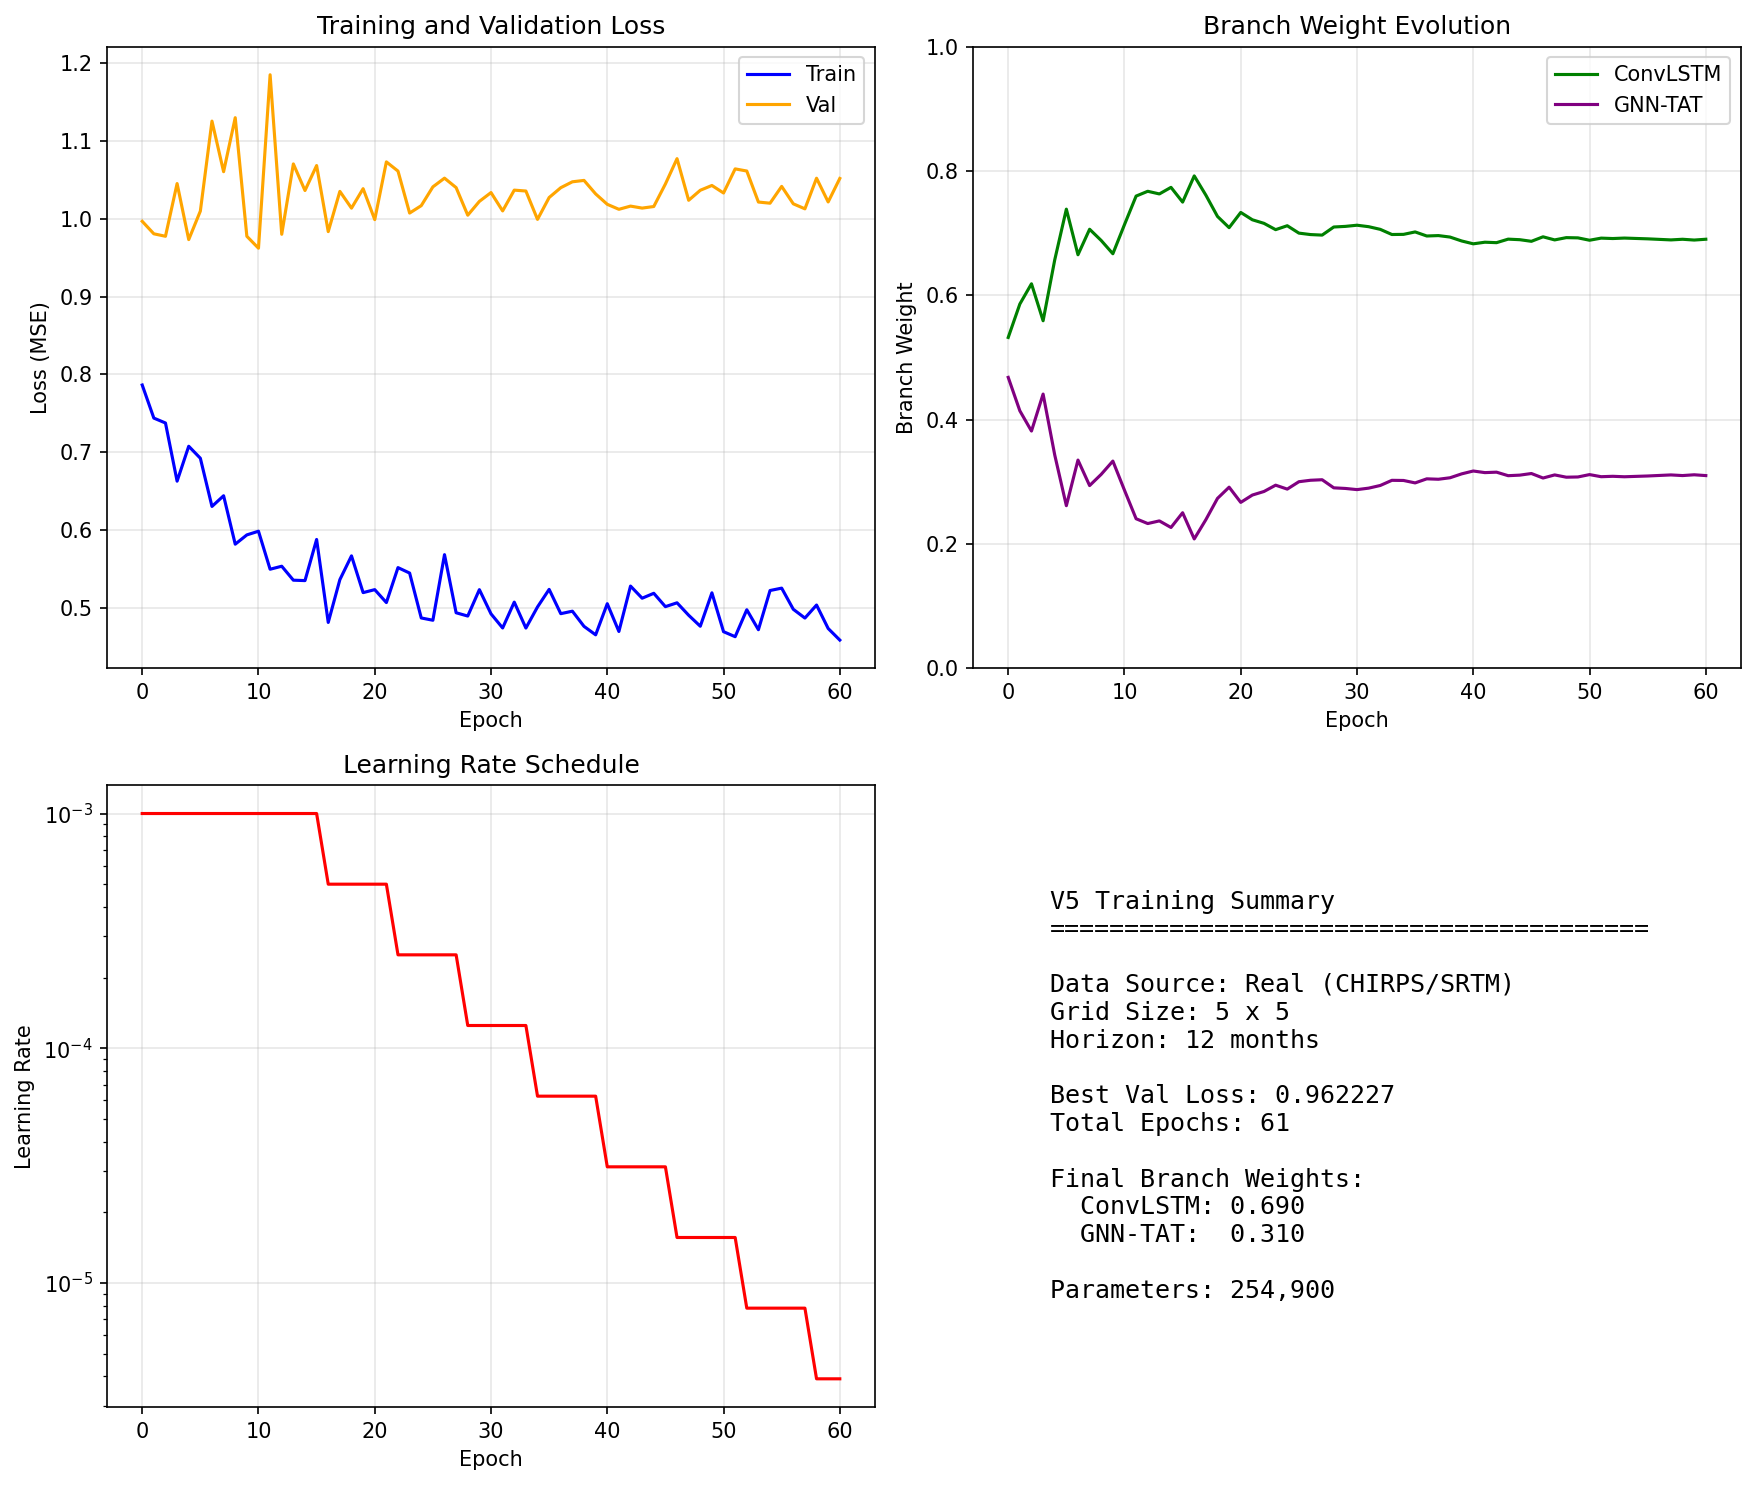


Figure saved: models/output/V5_STACKING/v5_training_curves.png


In [19]:
# =============================================================================
# 6.3 Visualize Training Results
# =============================================================================

import matplotlib.pyplot as plt

history = trainer.history

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Loss curves
ax1 = axes[0, 0]
ax1.plot(history['epoch'], history['train_loss'], label='Train', color='blue')
ax1.plot(history['epoch'], history['val_loss'], label='Val', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Branch weights evolution
ax2 = axes[0, 1]
ax2.plot(history['epoch'], history['branch_weights_convlstm'],
         label='ConvLSTM', color='green')
ax2.plot(history['epoch'], history['branch_weights_gnn'],
         label='GNN-TAT', color='purple')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Branch Weight')
ax2.set_title('Branch Weight Evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# 3. Learning rate
ax3 = axes[1, 0]
ax3.plot(history['epoch'], history['learning_rate'], color='red')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# 4. Final summary
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
V5 Training Summary
{'='*40}

Data Source: {'Real (CHIRPS/SRTM)' if USE_REAL_DATA else 'Synthetic'}
Grid Size: {config.n_lat} x {config.n_lon}
Horizon: {HORIZON} months

Best Val Loss: {trainer.best_val_loss:.6f}
Total Epochs: {len(history['epoch'])}

Final Branch Weights:
  ConvLSTM: {history['branch_weights_convlstm'][-1]:.3f}
  GNN-TAT:  {history['branch_weights_gnn'][-1]:.3f}

Parameters: {param_counts['total']:,}
"""
ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, fontsize=12,
         verticalalignment='center', fontfamily='monospace')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'v5_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved: {OUTPUT_DIR / 'v5_training_curves.png'}")


## 7. Next Steps

### Immediate (Phase 1 - Weeks 1-2)
1. [ ] Copy full graph construction from V4
2. [ ] Implement real data loading pipeline
3. [ ] Add feature preprocessing (BASIC, KCE separation)

### Short-term (Phase 2 - Weeks 3-4)
4. [ ] Full training loop with checkpointing
5. [ ] Memory optimization (gradient checkpointing)
6. [ ] Initial experiments on light mode (5x5 grid)

### Medium-term (Phase 3 - Weeks 5-7)
7. [ ] Full grid experiments (61x65)
8. [ ] Ablation studies (A1-A6)
9. [ ] Branch weight analysis by elevation

### Paper Preparation (Phase 4 - Weeks 8-11)
10. [ ] Statistical significance tests
11. [ ] Generate figures (700 DPI)
12. [ ] Paper-5 draft writing

---

*Notebook created: January 2026*  
*Status: PROTOTYPE - Architecture validated with synthetic data*